In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import models, transforms
import torchvision.datasets as dset
import torchvision.transforms as T

from torch.utils.data import DataLoader 
from torch.utils.data import sampler
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
import os.path as osp
from PIL import Image

plt.ion()   # interactive mode

In [2]:
class MOVIES(Dataset):

# A customized data loader for MNIST.\n",
    def __init__(self, root,transform=None,preload=False, train=True):
#             Intialize the MNIST dataset,
#             Args:,
#                 - root: root directory of the dataset
#                 - transform: a custom tranform function
#                 - preload: if preload the dataset into memory
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform
        self.train = train
            
        for i in range(10):
            filenames = glob.glob(osp.join(root, str(i), '*.jpg'))
            for fn in filenames:
                self.filenames.append((fn, i)) # (filename, label)

        # if preload dataset into memory",
        if preload:
            self._preload()

        self.len = len(self.filenames)

    def _preload(self):

#        Preload dataset to memory

        self.labels = []
        self.images = []
        for image_fn, label in self.filenames:            
            # load images
            image = Image.open(image_fn)
            # avoid too many opened files bug
            self.images.append(image.copy())
            image.close()
            self.labels.append(label)

    def __getitem__(self, index):
#              Get a sample from the dataset

        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
            label = self.labels[index]
        else:
            # If on-demand data loading
            image_fn, label = self.filenames[index]
            image = Image.open(image_fn)

        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
        # return image and label
        return image, label

    def __len__(self):

#             Total number of samples in the dataset
        return self.len

In [3]:
DataSetFolder = 'datasets/split_drama_posters/train/'
DataSetFolder_test = 'datasets/split_drama_posters/test/'

NUM_TRAIN = 4000
NUM_TOTALIMAGES = 4291

BATCHSIZE = 32 #cifar10 set to 64
R_Mean = .4
G_Mean = .4
B_Mean = .4
R_Std = .01
G_Std = .01
B_Std = .01


In [4]:
## This cell is drafted after Assignment2 Pytorch - but those images were already square!!!!

## to normalize by subtracting the mean RGB vlaue and dividing by the standard deviations of each RGB value
## the Mean and STD are from CIFAR10 dataset
data_transforms = T.Compose([
                T.Resize((224,224)),
                T.ToTensor()])
#                 T.Normalize((R_Mean, G_Mean, B_Mean), (R_Std, G_Std, B_Std))])

dataloaders = {}
poster_train = MOVIES(DataSetFolder, preload=False, transform=data_transforms, train=True)
# loader_train = DataLoader(poster_train, batch_size=BATCHSIZE, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
dataloaders['train'] = DataLoader(poster_train, batch_size=BATCHSIZE, 
                                  sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

poster_val = MOVIES(DataSetFolder, preload=False, transform=data_transforms, train=True)
# loader_val = DataLoader(poster_val, batch_size=BATCHSIZE, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TOTALIMAGES)))
dataloaders['val'] = DataLoader(poster_val, batch_size=BATCHSIZE, 
                                sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TOTALIMAGES)))

poster_test = MOVIES(DataSetFolder_test, preload=False, transform=data_transforms, train=False)
loader_test = DataLoader(poster_test, batch_size=BATCHSIZE)

dataset_sizes = {}
dataset_sizes['train'] = len(dataloaders['train'])
dataset_sizes['val'] = len(dataloaders['val'])

In [5]:
# # this is from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# # why is resize two different values?????
# # where is the number of training and validation images set?

# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([R_Mean, G_Mean, B_Mean], [R_std, G_Std, B_Std])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([R_Mean, G_Mean, B_Mean], [R_std, G_Std, B_Std])
#     ]),
# }

# image_datasets = {x: datasets.ImageFolder(os.path.join(DataSetFolder, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}

# # num_workers (int, optional) – how many subprocesses to use for data loading. 
# # 0 means that the data will be loaded in the main process. (default: 0)
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCHSIZE,
#                                              shuffle=True, num_workers=4)  
#               for x in ['train', 'val']}

# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes



In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tensor(1) tensor(0) tensor(0) tensor(0) tensor(0) tensor(0) tensor(1) tensor(1) tensor(1) tensor(1) tensor(0) tensor(1) tensor(0) tensor(1) tensor(1) tensor(1) tensor(1) tensor(1) tensor(0) tensor(0) tensor(1) tensor(0) tensor(0) tensor(0) tensor(0) tensor(0) tensor(0) tensor(1) tensor(1) tensor(1) tensor(0) tensor(1)


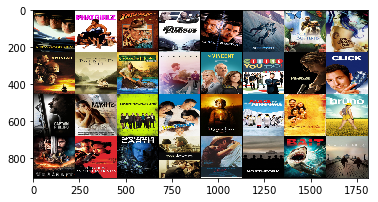

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(BATCHSIZE)))

In [30]:
# def imshow(inp, title=None):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated


# # Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

NameError: name 'class_names' is not defined

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
#                 scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 19.6787 Acc: 21.1440
val Loss: 15.7609 Acc: 21.4000

Epoch 1/24
----------
train Loss: 19.3584 Acc: 21.5840
val Loss: 16.1004 Acc: 21.1000

Epoch 2/24
----------
train Loss: 19.3428 Acc: 21.5760
val Loss: 17.2148 Acc: 19.7000

Epoch 3/24
----------


RuntimeError: $ Torch: not enough memory: you tried to allocate 0GB. Buy new RAM! at /opt/conda/conda-bld/pytorch_1524590031827/work/aten/src/TH/THGeneral.c:218

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()